# Day 21, expressive symians

Today's puzzle forms an acyclic directed graph of expressions. Simply construct the graph and compute the expression!

In [1]:
import operator
from dataclasses import dataclass
from typing import Callable, Final


OPERATORS: Final[dict[str, Callable[[int, int], int]]] = {
    "+": operator.add,
    "*": operator.mul,
    "-": operator.sub,
    "/": operator.truediv,
}


@dataclass
class Monkey:
    name: str

    def __call__(self, expr: "MonkeyExpression") -> int:
        raise NotImplementedError

    @classmethod
    def from_string(cls, string: str) -> "Monkey":
        name, *parts = string.split()
        name = name[:-1]
        match parts:
            case [value]:
                return ValueMonkey(name, int(value))
            case [left, operator, right] if operator in OPERATORS:
                return ExpressionMonkey(name, left, right, OPERATORS[operator])
            case _:
                raise ValueError("Invalid monkey expression")


@dataclass
class ExpressionMonkey(Monkey):
    left: str
    right: str
    operator: Callable[[int, int], int]

    def __call__(self, monkeys: dict[str, Monkey]) -> int:
        left, right = monkeys[self.left], monkeys[self.right]
        return self.operator(left(monkeys), right(monkeys))


@dataclass
class ValueMonkey(Monkey):
    value: int

    def __call__(self, *_) -> int:
        return self.value


@dataclass
class MonkeyExpression:
    monkeys: dict[str, Monkey]

    @classmethod
    def from_text(cls, text: str) -> "MonkeyExpression":
        return cls(
            {(m := Monkey.from_string(line)).name: m for line in text.splitlines()}
        )

    def __getitem__(self, name: str) -> Monkey:
        return self.monkeys[name]

    def __call__(self) -> int:
        return int(self.monkeys["root"](self.monkeys))


example = MonkeyExpression.from_text(
    """\
root: pppw + sjmn
dbpl: 5
cczh: sllz + lgvd
zczc: 2
ptdq: humn - dvpt
dvpt: 3
lfqf: 4
humn: 5
ljgn: 2
sjmn: drzm * dbpl
sllz: 4
pppw: cczh / lfqf
lgvd: ljgn * ptdq
drzm: hmdt - zczc
hmdt: 32
"""
)
assert example() == 152

In [2]:
import aocd


expression = MonkeyExpression.from_text(aocd.get_data(day=21, year=2022))
print("Part 1:", expression())

Part 1: 353837700405464


## Part 2: solving the monkey puzzle tree

Suddenly, the tree turns out to be an equality equation. So lets turn it into one! We've used the [`sympy` symbolic math library](https://www.sympy.org/en/) before, specifically, for [2019, Day 2 (part 2)](../2019/Day%2002.ipynb) and for [2021, Day 24](../2021/Day%2024.ipynb).  Lets use that again here. We want to [solve an equation numerically](https://docs.sympy.org/latest/modules/solvers/solvers.html#sympy.solvers.solvers.nsolve), that is, give sympy our series of monkeys (symbols) and have it produce the value for `humn`.

This requires two updates:

- Calling the `humn` entry in the graph should produce a `sympy.Symbol()` object; it's the only variable in the expression.
- The root operator is replaced by `sympy.Eq()`
- Sympy produces a floating point value that is a very, very small fraction off from being an integer. Using `round()` on the result produces the proper integer result. You can't use `int()` because that'd floor the result, but the floating point value could be close but _lower_ than the actual integer answer.

In [3]:
from dataclasses import replace

import sympy as sy


def to_sympy(expr: MonkeyExpression) -> sy.Expr:
    # replace floor division with true division
    monkeys = expr.monkeys.copy()
    # use a sympy symbol for the human in the equation.
    monkeys["humn"] = replace(monkeys["humn"], value=sy.Symbol("humn"))
    # replace the root operator with the equality operator from sympy
    root = replace(monkeys["root"], operator=sy.Eq)
    return sy.nsimplify(root(monkeys), rational=True)


def solve_for_human(expr: MonkeyExpression) -> int:
    # and solve the equation numerically.
    return round(sy.nsolve(to_sympy(expr), 0))


assert solve_for_human(example) == 301

In [4]:
print("Part 2:", solve_for_human(expression))

Part 2: 3678125408017


## Visualisations

### Example expression

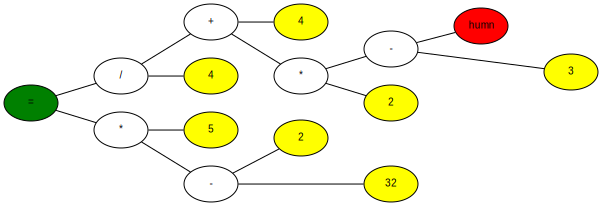

Eq(humn/2 - 1/2, 150)

### Puzze input expression

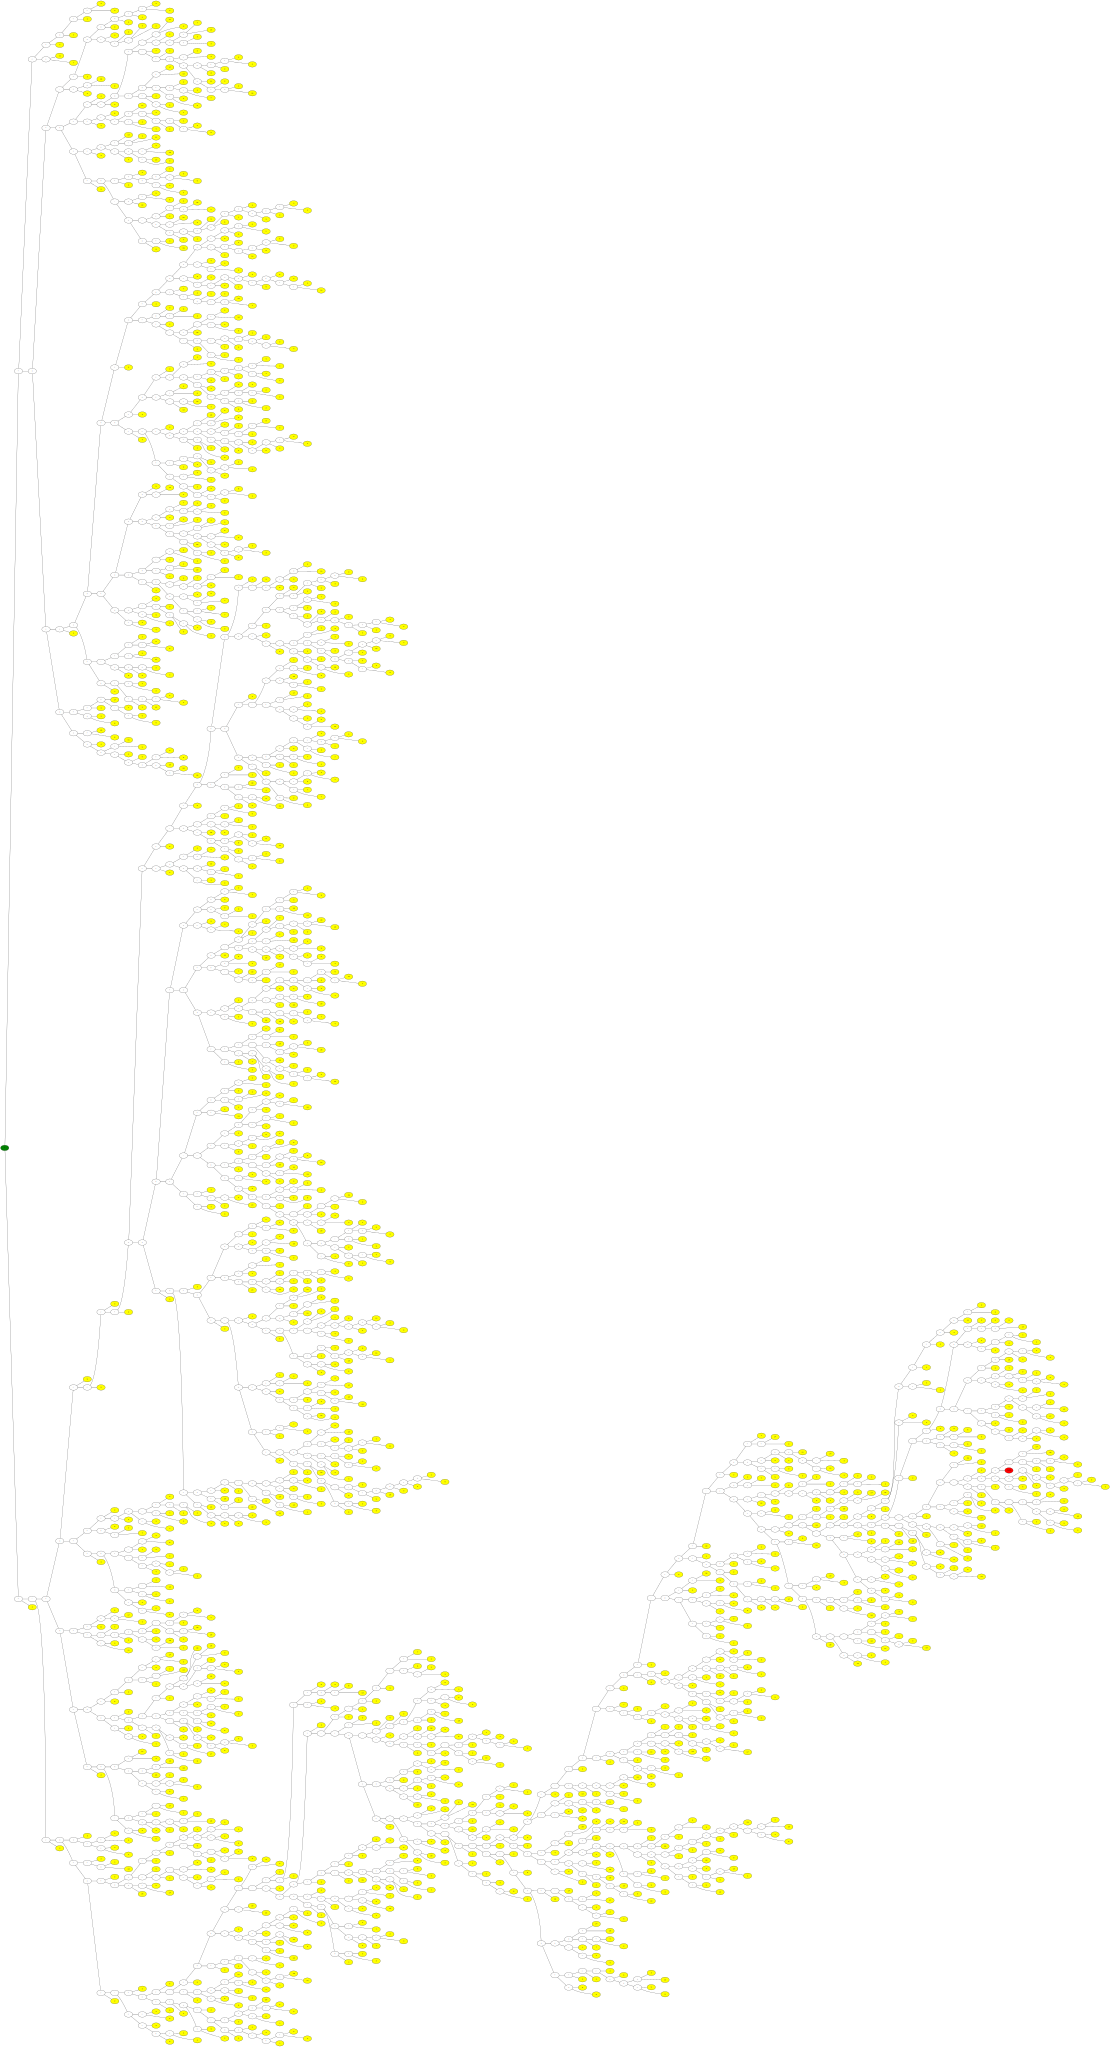

Eq(237683443649574 - 61952*humn/1875, 116154256834924)

In [5]:
import subprocess

import graphviz
from IPython.display import display, Markdown
from sympy.simplify.cse_main import opt_cse


def plot_expression(
    expr: MonkeyExpression,
    edge_attr: dict[str, str] | None = None,
    node_attr: dict[str, str] | None = None,
    **graph_attr: str,
) -> graphviz.Digraph:
    graph_attr = {
        "ratio": "compress",
        "rankdir": "LR",
        **graph_attr,
    }
    edge_attr = {
        "fontname": "Arial,Helvetica Neue,Helvetica,sans-serif",
        "fontsize": "10.0",
        "dir": "none",
        **(edge_attr or {}),
    }
    node_attr = {
        "fontname": "Arial,Helvetica Neue,Helvetica,sans-serif",
        "fontsize": "10.0",
        "fixedsize": "true",
        "style": "filled",
        **(node_attr or {}),
    }
    dot = graphviz.Digraph("MonkeyExpression", strict=True)
    dot.attr(**graph_attr)
    dot.attr("edge", **edge_attr)
    dot.attr("node", **node_attr)
    colours = {"root": "green", "humn": "RED"}
    ops = {operator.sub: "-", operator.add: "+", operator.mul: "*", operator.truediv: "/"}
    for expr in expr.monkeys.values():
        match expr:
            case ExpressionMonkey(name, left, right, op):
                label = "=" if name == "root" else ops[op]
                dot.node(name, label, fillcolor=colours.get(name, "white"))
                dot.edge(name, left)
                dot.edge(name, right)
            case ValueMonkey(name, value):
                label = "humn" if name == "humn" else str(value)
                dot.node(name, label, fillcolor=colours.get(name, "yellow"))

    try:
        # attempt to process the graph through unflatten, if available
        result = subprocess.run(
            ["unflatten", "-l3"], input=dot.source, capture_output=True, encoding="utf8"
        )
        if result.returncode == 0:
            dot = graphviz.Source(result.stdout)
    except OSError:
        pass

    return dot


display(Markdown("## Visualisations\n\n### Example expression"))
display(plot_expression(example))
display(to_sympy(example))

display(Markdown("### Puzze input expression"))
display(plot_expression(expression))
display(to_sympy(expression))

